## Welcome to the Planetary Data Reader Example Jupyter Notebook!

The Planetary Data Reader (`pdr`) is a Python package that provides a single, straightforward interface to planetary science observational data. It is currently under active development and will eventually support almost all data hosted by the Planetary Data System (PDS). The basic command is: `pdr.read(fn)`, where `fn` is either an observational data file or its detached label file (if one exists).

This notebook demonstrates basic usage and key features of `pdr`.

_**Note:** This notebook downloads data from the PDS, so it requires an internet connection. You do not need an internet connection to use `pdr` with data that is already on your computer._

In [1]:
# glob, os, and requests are used to check paths and retrieve remote data in this notebook. you do 
# not need to import them for most uses of pdr.
import glob
import os 

import requests 

# importing the pdr module itself is mandatory for most uses of pdr.
import pdr  

First, we'll look at an image product from the Lunar Reconnaissance Orbiter's Narrow Angle Camera system. This product uses the older PDS3 standard. It has an attached label, so there's only one file to fetch.

In [2]:
# URL for the data file on the PDS server
img_url = 'https://pds.lroc.asu.edu/data/LRO-L-LROC-5-RDR-V1.0/LROLRC_2001/DATA/BDR/NAC_ROI/NECTARISLOA/NAC_ROI_NECTARISLOA_E176S0413_20M.IMG'
filename = img_url.split('/')[-1]
# This retrieves the file and saves it to the current working directory.
# It will print the total data volume in bytes (8227536) when it completes.
if not os.path.exists(filename):
    req = requests.get(img_url)
    open(filename, 'wb').write(req.content)
    print(len(req.content))

8227536


### Reading image data:
Now that we've downloaded our file by running the previous cell, we can easily read the data in with `pdr.read()`. `read` returns a `Data` object with attributes that correspond to the names of the data objects as defined in the label. Much like a Python `dict`, the attributes of this object can be queried with `__getitem__` notation (["thing"]) and accessed with a `keys()` method. 

Let's read the file and see what kinds of data it contains.

In [3]:
lroc_data = pdr.read(filename)  # That's the magic function call!
print(f'The keys are {lroc_data.keys()}')

The keys are ['LABEL', 'IMAGE', 'DATA_SET_MAP_PROJECTION']


If you are not familiar with PDS data formats, you might be surprised to learn that this "image" file contains three different data objects. Most PDS3 products have a `LABEL` object, which contains metadata associated with an observation (like observation time, calibration constants, provenance information, etc.). `pdr` interprets this metadata as a `pdr.Metadata` object, and will also print the raw `LABEL` as plain text. The `IMAGE` object is an array of observational data values; `pdr` interprets it as a `numpy.ndarray`. `DATA_SET_MAP_PROJECTION`, which is included in some map-projected PDS3 data products, contains information about the map projection.

You can access these objects with `dict`-style item notation (`data[KEY]`) or attribute notation (`data.KEY`). For instance, if you'd like to examine the IMAGE values, you can run:

In [4]:
lroc_data.IMAGE

array([[-3.4028227e+38, -3.4028227e+38, -3.4028227e+38, ...,
        -3.4028227e+38, -3.4028227e+38, -3.4028227e+38],
       [-3.4028227e+38, -3.4028227e+38, -3.4028227e+38, ...,
        -3.4028227e+38, -3.4028227e+38, -3.4028227e+38],
       [-3.4028227e+38, -3.4028227e+38, -3.4028227e+38, ...,
        -3.4028227e+38, -3.4028227e+38, -3.4028227e+38],
       ...,
       [-3.4028227e+38, -3.4028227e+38, -3.4028227e+38, ...,
        -3.4028227e+38, -3.4028227e+38, -3.4028227e+38],
       [-3.4028227e+38, -3.4028227e+38, -3.4028227e+38, ...,
        -3.4028227e+38, -3.4028227e+38, -3.4028227e+38],
       [-3.4028227e+38, -3.4028227e+38, -3.4028227e+38, ...,
        -3.4028227e+38, -3.4028227e+38, -3.4028227e+38]], dtype=float32)

Let's go ahead and print all the keys out to see what this product's data objects are like. 

In [5]:
for key in lroc_data.keys():
    print(f'{key}:')
    print(lroc_data[key])

LABEL:
PDS_VERSION_ID            = PDS3

/* The source image data definition. */
RECORD_TYPE   = FIXED_LENGTH
RECORD_BYTES  = 4344
FILE_RECORDS  = 1894
LABEL_RECORDS = 2
^IMAGE        = 3

/* Identification Information  */
DATA_SET_ID               = "LRO-L-LROC-5-RDR-V1.0"
DATA_SET_NAME             = "LRO MOON LROC 5 RDR V1.0"
VOLUME_ID                 = "LROLRC_2001"
PRODUCER_INSTITUTION_NAME = "ARIZONA STATE UNIVERSITY"
PRODUCER_ID               = LRO_LROC_TEAM
PRODUCER_FULL_NAME        = "MARK ROBINSON, PH.D"
PRODUCT_ID                = NAC_ROI_NECTARISLOA_E176S0413_20M
PRODUCT_VERSION_ID        = "v1.3"
PRODUCT_TYPE              = RDR
INSTRUMENT_HOST_NAME      = "LUNAR RECONNAISSANCE ORBITER"
INSTRUMENT_HOST_ID        = LRO
INSTRUMENT_NAME           = "LUNAR RECONNAISSANCE ORBITER CAMERA"
INSTRUMENT_ID             = LROC
TARGET_NAME               = MOON
MISSION_PHASE_NAME        = "THIRD EXTENDED SCIENCE MISSION"
RATIONALE_DESC            = "Created to enable lunar science and exp

/home/michael/Desktop/pdr/pdr/pdr.py:456: UserWarning: DATA_SET_MAP_PROJECTION file /home/michael/Desktop/pdr/DSMAP.CAT not found in path.
  warnings.warn(


**Oopsie!** `pdr` failed to load `DATA_SET_MAP_PROJECTION` and threw a `UserWarning` when we attempted to access it. This is intentional. Many files in the PDS have small format (.FMT), catalog (.CAT), or other supplementary files referenced in their labels. These files are usually not stored in the same directory on the PDS's servers as the data and label files. Most of the time, these supplementary files will not be necessary to read the objects you care about: note that we accessed the `LABEL` and `IMAGE` objects with no issues. However, if they are necessary and are not in your filesystem, `pdr` cannot load them and will throw an error when you attempt to access associated data objects.

#### `.show()` convenience method (for visualizing image data):
`pdr` has a convenience method called `.show()` which helps to quickly visualize image data. Null values---typically defined in the label or drawn from a list of universal null values---are masked in cyan, but that doesn't change their value in the data object. This method is solely for visualizing data for browsing or triage purposes. (If you want an array containing the specific values used to render these images, use `data.get_scaled("NAME_OF_OBJECT")`.)

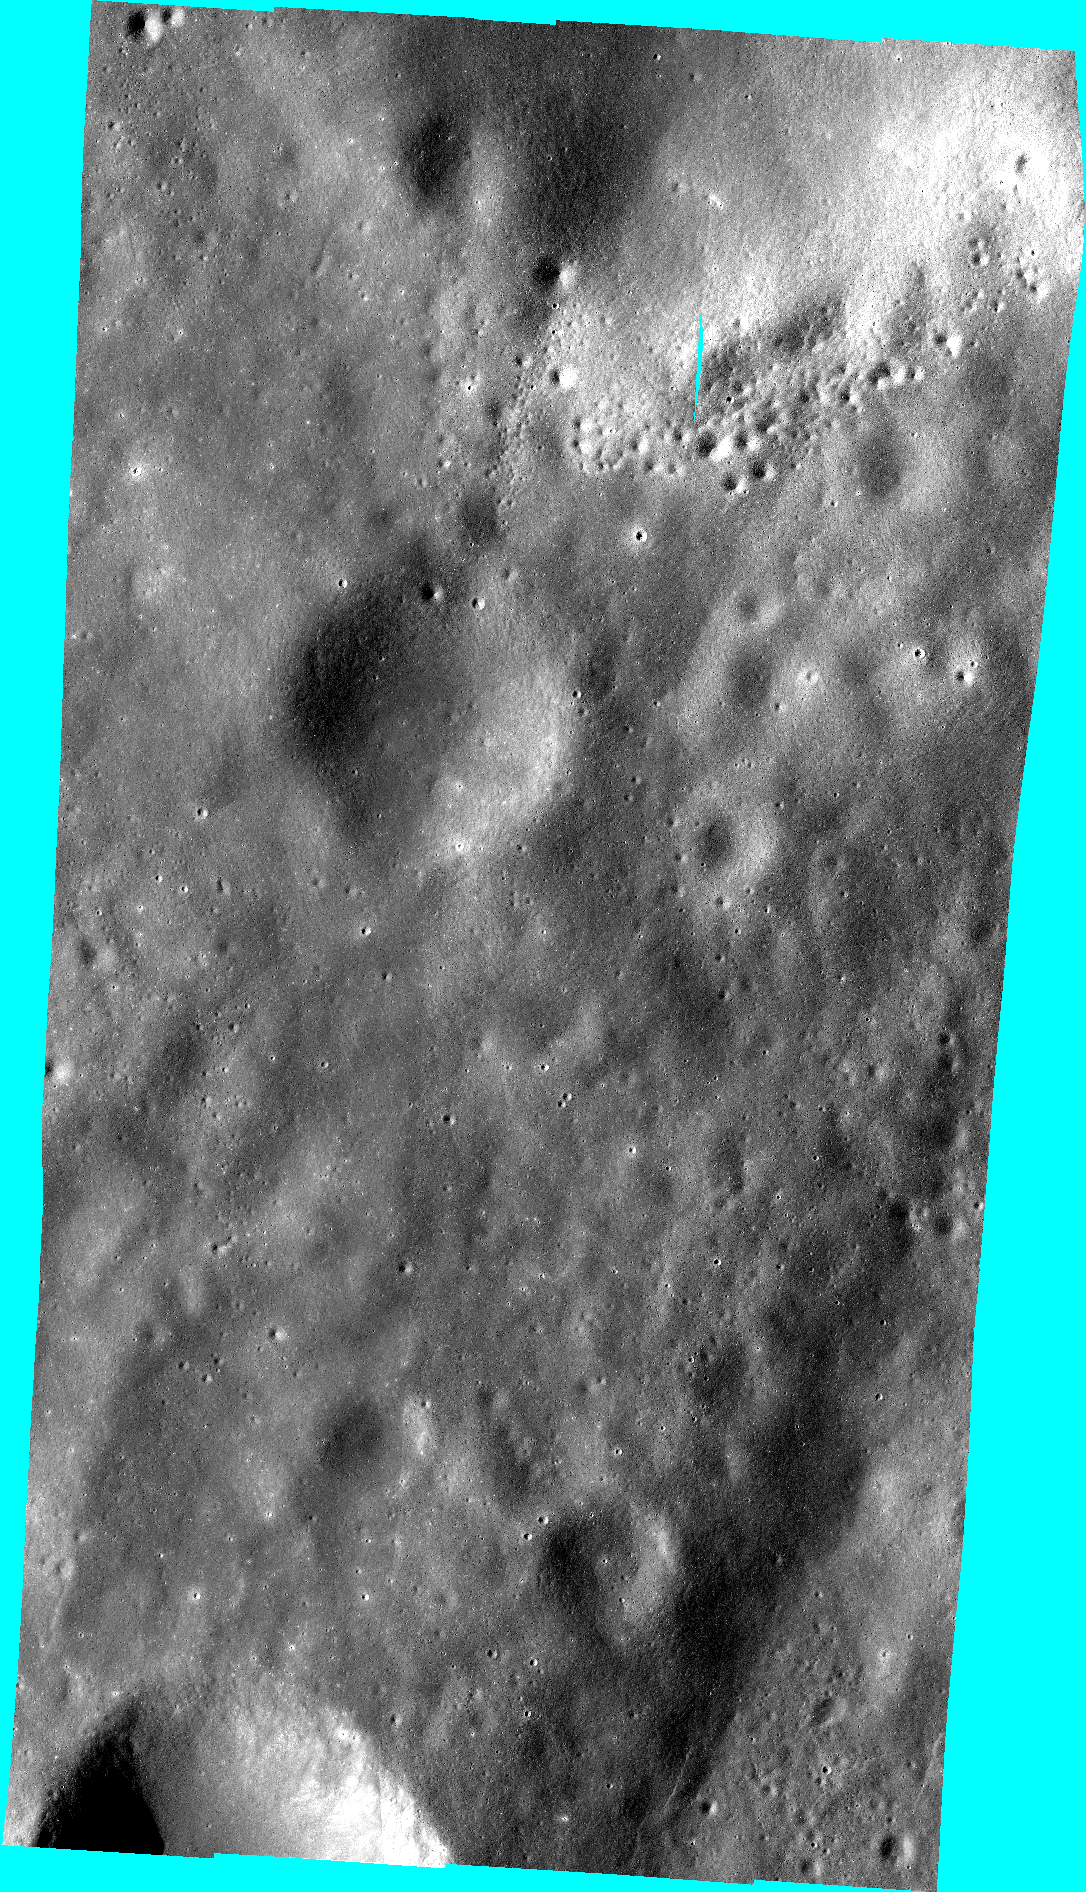

In [6]:
lroc_data.show()

### Reading table data:
Now let's look at some table-like data products.  The same `pdr.read()` command works. `pdr` will figure out the format of the table and loads it as a `pandas.DataFrame`.

First we'll read a table from the Apollo 15 Heat Flow Experiment that is in the PDS4 format. Then we'll read some MRO SHARAD data that is in the PDS3 format. We also demonstrate that data can be opened with either a detached label file or a data file, although **label files are preferred.**

_**Note:** `pdr` wraps `pds4_tools` to open PDS4 data. Sometimes this is less optimized, resulting in slower (though still accurate) reads. For this reason, **we recommend using PDS3 labels whenever both types of label are available.**

In [7]:
# These are URLs for Apollo 15 HFE data and label files
apollo_url = 'https://pds-geosciences.wustl.edu/lunar/'\
             'urn-nasa-pds-a15_17_hfe_concatenated/data/split/a15p1f4_split.tab'
apollo_lbl = 'https://pds-geosciences.wustl.edu/lunar/'\
             'urn-nasa-pds-a15_17_hfe_concatenated/data/split/a15p1f4_split.xml'
# This downloads the data, same way as above
apollo_fn = apollo_url.split('/')[-1]
if not os.path.exists(apollo_fn):
    req = requests.get(apollo_url)
    open(apollo_fn, 'wb').write(req.content)
apollo_lbl_fn = apollo_lbl.split('/')[-1]
if not os.path.exists(apollo_lbl):
    reqlbl = requests.get(apollo_lbl)
    open(apollo_lbl_fn, 'wb').write(reqlbl.content)
apollo_from_data_file = pdr.read(apollo_fn)
apollo_from_lbl_file = pdr.read(apollo_lbl_fn)
# This checks that the outputs of `pdr` are identical 
# whether you pass it the data file or the label file.
print(
    'Do the data file and label file produce identical outputs?',
    all(apollo_from_data_file['a15p1f4_split']==apollo_from_lbl_file['a15p1f4_split'])
)

Do the data file and label file produce identical outputs? True


this table is just a `DataFrame`. You can use it exactly like you'd use any other `DataFrame`.

For instance, to quickly get descriptive statistics about the regolith temperature at the 
"TR11A" thermometer during the measured interval (1971-1974): 


In [8]:
apollo_from_data_file.a15p1f4_split['TR11A'].describe()

count    611.000000
mean     252.620610
std        0.907045
min      250.014990
25%      252.075480
50%      252.601240
75%      253.326235
max      254.420000
Name: TR11A, dtype: float64

Here's an example with a MRO-RSS product (in PDS3 format):

In [9]:
mrorss_url = 'https://pds-geosciences.wustl.edu/mro/mro-m-rss-5-sdp-v1/'\
             'mrors_1xxx/data/shadr/jgmro_110b2_sha.tab'
mrorss_lbl_url = 'https://pds-geosciences.wustl.edu/mro/mro-m-rss-5-sdp-v1/'\
                 'mrors_1xxx/data/shadr/jgmro_110b2_sha.lbl'
mrorss_fn = mrorss_url.split('/')[-1]
if not os.path.exists(mrorss_fn):
    req = requests.get(mrorss_url)
    open(mrorss_fn, 'wb').write(req.content)
mrorss_lbl = mrorss_lbl_url.split('/')[-1]
if not os.path.exists(mrorss_lbl):
    req_lbl = requests.get(mrorss_lbl_url)
    open(mrorss_lbl, 'wb').write(req_lbl.content)

mrorss_data=pdr.read(mrorss_lbl)
mrorss_data

pdr.Data(/home/michael/Desktop/pdr/jgmro_110b2_sha.lbl)
keys=['LABEL', 'SHADR_HEADER_TABLE', 'SHADR_COEFFICIENTS_TABLE']
not yet loaded: ('LABEL', 'SHADR_HEADER_TABLE', 'SHADR_COEFFICIENTS_TABLE')

Note the "not yet loaded" message. `pdr` lazily loads data. This means that it does not load data objects on initialization, but rather when they are first referenced. This allows you to load individual data objects at your leisure. This can provide serious savings in computational resources for large files, or for products with many separate objects (some of which you likely do not care about).

In [10]:
# now we can load individual objects by simply referencing
# the attribute. note that this TABLE no longer appears in 
# the 'not yet loaded' list.
print(mrorss_data.SHADR_COEFFICIENTS_TABLE['C'].mean())
mrorss_data

-1.5051263674907255e-07


pdr.Data(/home/michael/Desktop/pdr/jgmro_110b2_sha.lbl)
keys=['LABEL', 'SHADR_HEADER_TABLE', 'SHADR_COEFFICIENTS_TABLE']
not yet loaded: ('LABEL', 'SHADR_HEADER_TABLE')

#### `.dump_browse()` convenience method (for outputting browse products of any data type)

Much like the `.show()` method, the `dump_browse()` method can output a masked browse image. However, there are some key differences.

(1) `.dump_browse()` will create a browse file on your computer drive, not a visual output on your display.

(2) While `.show()` only works on array data (it is meant for images), the `.dump_browse()` feature will create files for any loaded key.

Also note that **`.dump_browse` only works on loaded objects.** This is intentional but can be surprising. 

Let's give it a go:

In [11]:
mrorss_data.dump_browse()
print(glob.glob('jgmro_110b2_sha*'))

['jgmro_110b2_sha.tab', 'jgmro_110b2_sha.lbl', 'jgmro_110b2_sha_SHADR_COEFFICIENTS_TABLE.csv']


There should now be a new file in the folder you have this jupyter notebook in (visible in the printed `glob` statement above):

    - jgmro_110b2_sha_SHADR_COEFFICIENTS_TABLE.csv
    
Dumped browse filenames are created from the original filename, plus "\_key" (where 'key' is the name of the data object from the label, and therefore also the corresponding `pdr.Data` key).

Also note that `.dump_browse()` only created files for objects we had already loaded!

If we want to load all of the keys for a data object, we can pass the `'all'` argument to the `.load()` method:

In [12]:
mrorss_data.load('all')
mrorss_data

pdr.Data(/home/michael/Desktop/pdr/jgmro_110b2_sha.lbl)
keys=['LABEL', 'SHADR_HEADER_TABLE', 'SHADR_COEFFICIENTS_TABLE']

In [13]:
mrorss_data.dump_browse()

`dump_browse()` saves labels as plain .txt files. There should now be two more files in the folder you have this jupyter notebook in:

    -jgmro_110b2_sha_LABEL.txt
    -jgmro_110b2_sha_SHADR_HEADER_TABLE.csv

We can use this same convenience method with the image data from above (requires running the first 2 cells after import in case you jumped here). This will save the image we displayed above as a .jpg file, and also save its label as a .txt file.

In [14]:
lroc_data.dump_browse()
print(glob.glob('*NECTARIS*'))

['NAC_ROI_NECTARISLOA_E176S0413_20M_LABEL.txt', 'NAC_ROI_NECTARISLOA_E176S0413_20M_IMAGE.jpg', 'NAC_ROI_NECTARISLOA_E176S0413_20M.IMG']
